# Hierarchical Clustering Analysis - MASE


In this notebook, we will use multiple adjacency spectral embedding (MASE) instead of omnibus embedding to obtain a low dimensional vector representation of vertices in our correlation matrices

In [1]:
import pandas as pd
import graspologic as gp
import seaborn as sns
import hyppo
import matplotlib.pyplot as plt
import numpy as np

import plotly.graph_objects as go
import matplotlib.cm

from sklearn.preprocessing import LabelEncoder
%matplotlib inline

import plotly.io as pio
pio.renderers.default="png"

In [2]:
# ## Read the brain region information
# t = pd.read_excel("../data/raw/CHASSSYMM3AtlasLegends.xlsx", engine='openpyxl')

# pd.concat([t, cluster_label_df], axis=1).to_csv("CHASSSYMM3AtlasLegends.csv", index=False)

# out = pd.concat([node_labels, cluster_label_df], axis=1)

# out.to_csv("./out.csv")

In [3]:
## Read the data

key = pd.read_csv('../data/processed/key.csv')
data = pd.read_csv('../data/processed/mouses-volumes.csv')

data.set_index(key.DWI, inplace=True)

genotypes = ['APOE22', 'APOE33', 'APOE44']

gen_animals = {genotype: None for genotype in genotypes}

for genotype in genotypes:
    gen_animals[genotype] = key.loc[key['Genotype'] == genotype]['DWI'].tolist()

vol_dat = {genotype: [] for genotype in genotypes}
    
for genotype in genotypes:
    vol_dat[genotype] = data.loc[gen_animals[genotype]].to_numpy()
    
## Compute correlations
cor_dat = {genotype: gp.utils.symmetrize(np.corrcoef(dat, rowvar=False)) for (genotype, dat) in vol_dat.items()}

## Node hierarchical label data
node_labels = pd.read_csv("../data/processed/node_label_dictionary.csv")

In [4]:
node_labels

Structure  \
0                            Cingulate_Cortex_Area_24a   
1                      Cingulate_Cortex_Area_24a_prime   
2                            Cingulate_Cortex_Area_24b   
3                      Cingulate_Cortex_Area_24b_prime   
4                            Cingulate_Cortex_Area_29a   
..                                                 ...   
327                       IntermediateReticularNucleus   
328  PosteriorDorsal_ParaventricularMedialParvicell...   
329                                    Prerubral_Forel   
330                                PVG_of_Hypothalamus   
331                             Basal Lateral Amygdala   

                  Abbreviation Hemisphere      Level_1  \
0                         A24a       Left  1_forebrain   
1                    A24aPrime       Left  1_forebrain   
2                         A24b       Left  1_forebrain   
3                    A24bPrime       Left  1_forebrain   
4                         A29a       Left  1_forebrain   
..                         ...        ...          ...   
327                      IRN.1      Right  3_hindbrain   
328  PHD_PaMP_Post_and_LatHy.1      Right  1_forebrain   
329                PR_p3Tg_L.1      Right  1_forebrain   
330                      PVG.1      Right  1_forebrain   
331                      BLA.1      Right  1_forebrain   

                        Level_2                             Level_3  \
0    1_secondary_prosencephalon                         1_isocortex   
1    1_secondary_prosencephalon                         1_isocortex   
2    1_secondary_prosencephalon                         1_isocortex   
3    1_secondary_prosencephalon                         1_isocortex   
4    1_secondary_prosencephalon                         1_isocortex   
..                          ...                                 ...   
327         2_pontine_hindbrain                                 NaN   
328  1_secondary_prosencephalon  8_rostral_secondary_prosencephalon   
329              2_diencephalon                           p2_and_p3   
330  1_secondary_prosencephalon  8_rostral_secondary_prosencephalon   
331  1_secondary_prosencephalon                        6_subpallium   

                               Level_4  Subdivisions_7  index  index2  \
0                   2_cingulate_cortex     1_isocortex      1     1.0   
1                   2_cingulate_cortex     1_isocortex      2     2.0   
2                   2_cingulate_cortex     1_isocortex      3     3.0   
3                   2_cingulate_cortex     1_isocortex      4     4.0   
4                   2_cingulate_cortex     1_isocortex      5     5.0   
..                                 ...             ...    ...     ...   
327       axial_hindbrain_white_matter     6_hindbrain    328  1162.0   
328                     5_hypothalamus  4_diencephalon    329  1163.0   
329                        17_thalamus  4_diencephalon    330  1164.0   
330                     5_hypothalamus  4_diencephalon    331  1165.0   
331  8_pallial_and_subpallial_amygdala       2_pallium    332  1166.0   

     clusfound Subdivisions_7_nowm Hemisphere_abbrev Level_1_abbrev  
0            0         1_isocortex                 L             FB  
1            0         1_isocortex                 L             FB  
2            0         1_isocortex                 L             FB  
3            0         1_isocortex                 L             FB  
4            0         1_isocortex                 L             FB  
..         ...                 ...               ...            ...  
327          0         6_hindbrain                 R             HB  
328          0      4_diencephalon                 R             FB  
329          0      4_diencephalon                 R             FB  
330          0      4_diencephalon                 R             FB  
331          0           2_pallium                 R             FB  

[332 rows x 14 columns]

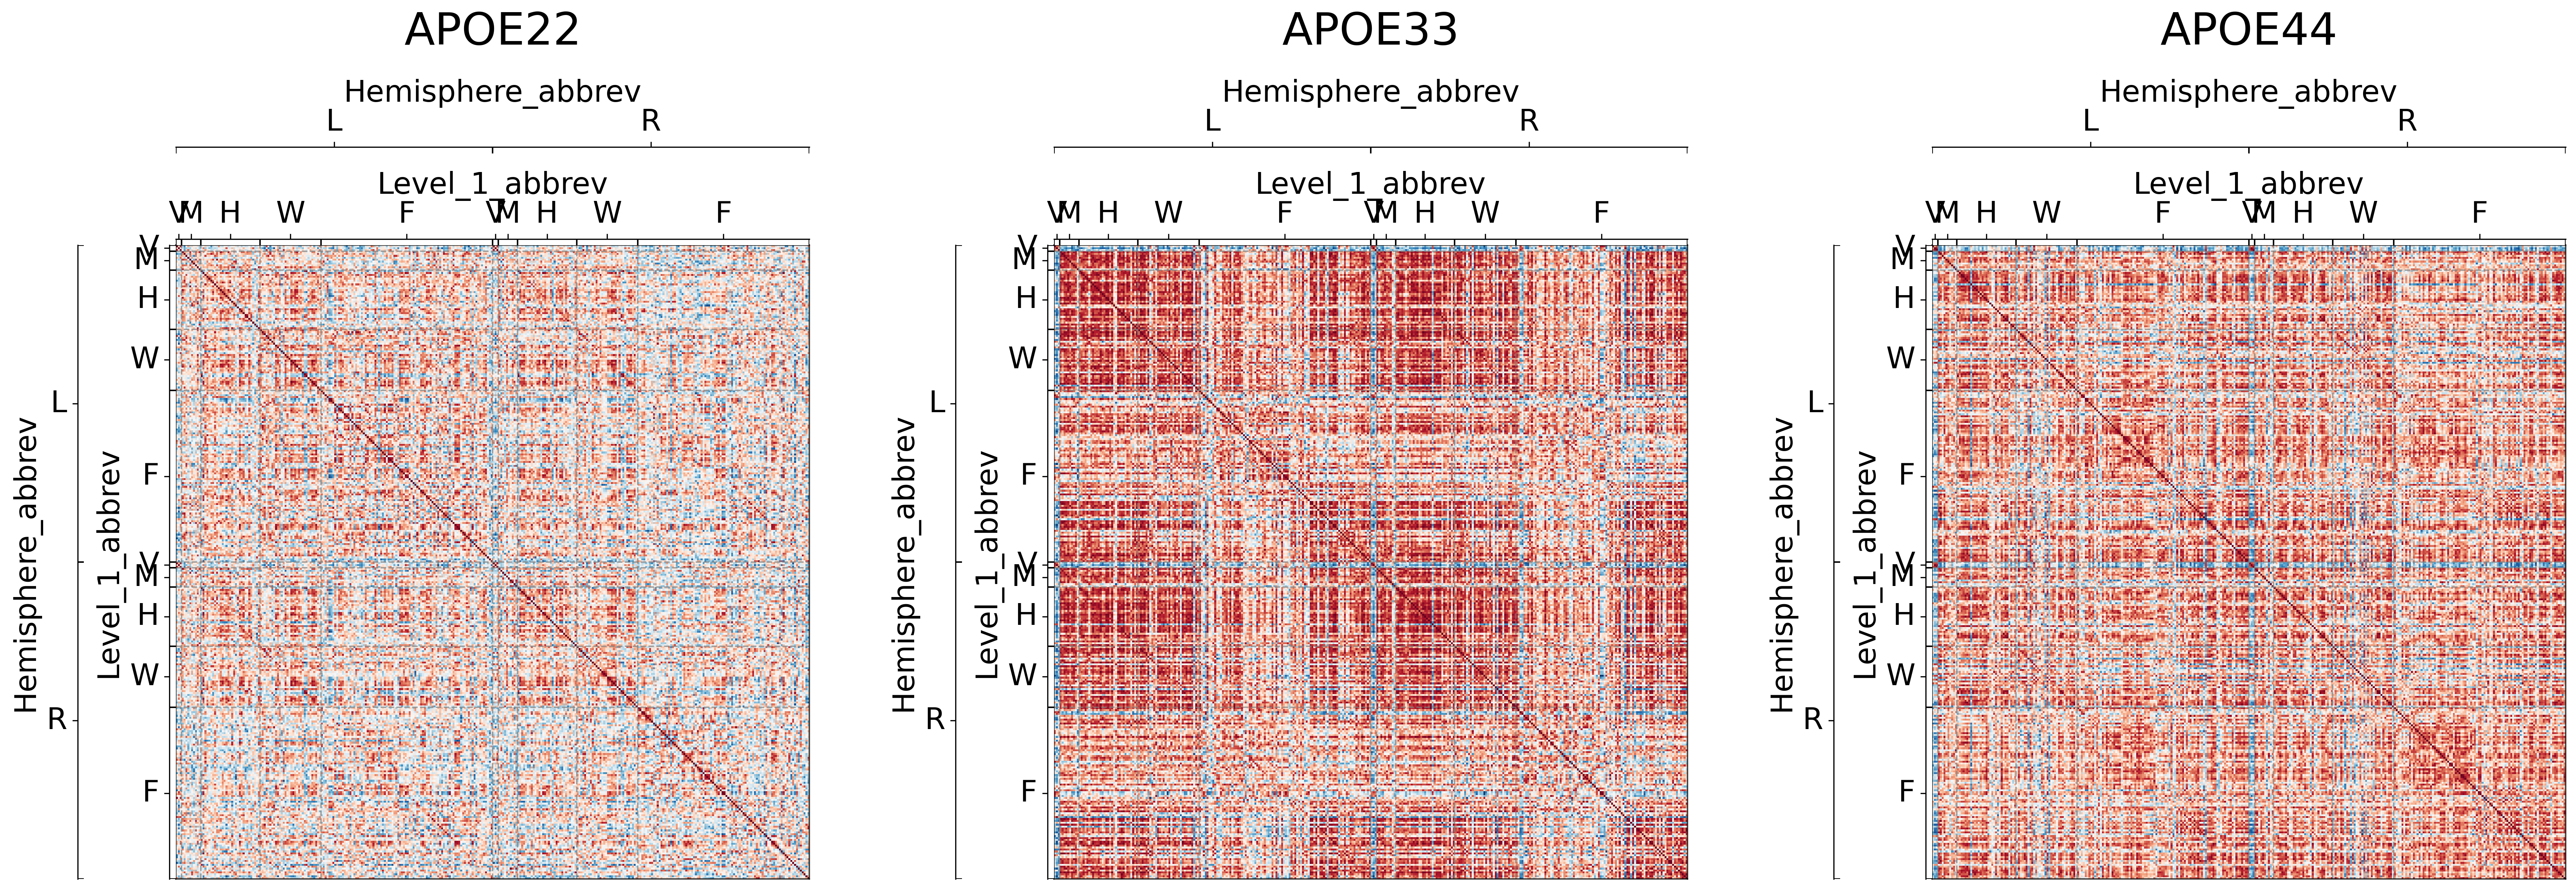

In [5]:
## Plot to make sure nothing is wrong
fig, ax = plt.subplots(
    ncols=3, 
    figsize=(30, 10), 
    #constrained_layout=True, 
    dpi=300,
    gridspec_kw=dict(width_ratios=[1, 1, 1])
)


for (i, genotype) in enumerate(cor_dat.keys()):
    gp.plot.adjplot(
        cor_dat[genotype], 
        ax=ax[i],
        vmin=-1,
        vmax=1,
        meta=node_labels,
        group=['Hemisphere_abbrev', 'Level_1_abbrev'],
    )
    ax[i].set_title(f"{genotype}", pad=135, size=30)
        
        
#fig.tight_layout(pad=3.0)

## Embed the data simultaneously using Multiple Adjacency Spectral Embedding (MASE)

The purpose of MASE is to obtain a low dimensional representation of the three correlation matrices such that the embedded correlation matrices can be compared to each other in a meaningful way {cite:p}`arroyo-mase`. Unlike omnibus embedding, MASE provides a common vertex representation across all correlation matrices. One can view this as a factoring out of common structures that are shared across all correlation matrices. This common representation of vertices provide a low dimensional vector per region of the brain, resulting in a $322\times d$ matrix per genotype where $d$ is the "embedding dimension" and $d << 332$. 

We will use the embeddings in order to perform hierchical clustering {cite:p}`athey2019autogmm,lyzinski2014perfect,priebe2019two`.

In [6]:
mase = gp.embed.MultipleASE()
Vhat = mase.fit_transform([corr for _, corr in cor_dat.items()])

Xhats = []

for score in mase.scores_:
    u, d, v = np.linalg.svd(score)
    Xhat = Vhat @ u @ np.diag(np.sqrt(d))
    
    Xhats.append(Xhat)

## Perform hierarchical clustering

First we concatenate the embeddings resulting in a matrix with size $332 \times 3d$. We will iteratively divide the regions into two clusters. For example, we divide the $332$ regions into two clusters, and each resulting cluster will be divided into two more clusters, etc. The clustering algorithm used at each division is Gaussian mixture modeling.

The clustering algorithm will tell us which regions should be grouped together, and subsequently forms our "subgraphs" given by the clusterings.

In [7]:
Vhat.shape

(332, 2)

In [8]:
cluster = gp.cluster.DivisiveCluster(max_level=3)

cluster_labels = cluster.fit_predict(Vhat, fcluster=True)

cluster_label_df = pd.DataFrame(cluster_labels, columns=["cluster_level_1", "cluster_level_2", "cluster_level_3"])

## Plotting the cluster labeling along with apriori labels using Sankey diagrams

Sankey diagrams tell us which regions or subregions belong to which clusters.

In [9]:
def count_groups(label_matrix):
    levels = label_matrix.shape[1] - 1
    d = []

    for level in range(levels):
        upper_cluster_ids = np.unique(label_matrix[:, level])
        
        for upper_cluster_id in upper_cluster_ids:
            lower_cluster_ids, counts = np.unique(
                label_matrix[label_matrix[:, level] == upper_cluster_id][:, level + 1], return_counts=True
            )

            for idx, lower_cluster_id in enumerate(lower_cluster_ids):
                if upper_cluster_id == lower_cluster_id:
                    lower_cluster_id = None
                d.append((upper_cluster_id, lower_cluster_id, counts[idx]))

    d = np.array(d)
    
    source = d[:, 0]
    target = d[:, 1]
    value = d[:, 2]
    
    return source, target, value

def append_apriori_labels(apriori_labels, cluster_matrix):
    encoder = LabelEncoder()
    apriori_labels_encoded = encoder.fit_transform(apriori_labels)
    apriori_labels_encoded = apriori_labels_encoded.reshape(-1, 1)
    
    # Increase the original cluster_matrix labels
    cluster_matrix_ = cluster_matrix + np.max(apriori_labels_encoded) + 1
    
    out = np.hstack([apriori_labels_encoded, cluster_matrix_])
    
    return out, list(encoder.classes_)

hemispheric_clusters, encoded_labels = append_apriori_labels(node_labels.Hemisphere, cluster_labels)

source, target, value = count_groups(hemispheric_clusters)

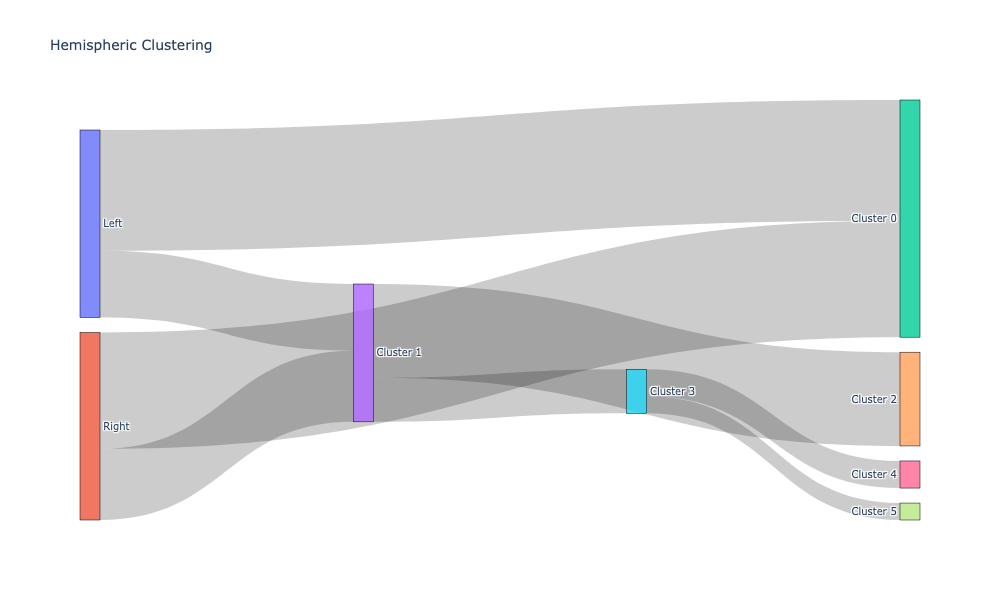

In [10]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = encoded_labels + [f"Cluster {i}" for i in range(np.max(hemispheric_clusters))]
    ),
    link = dict(
      source = source,
      target = target,
      value = value
  ))])

fig.update_layout(title_text="Hemispheric Clustering", font_size=10)
fig.show(dpi=300, width=1000, height=600)

In [11]:
level_1_clusters, encoded_labels = append_apriori_labels(node_labels.Level_1, cluster_labels)

source, target, value = count_groups(level_1_clusters)

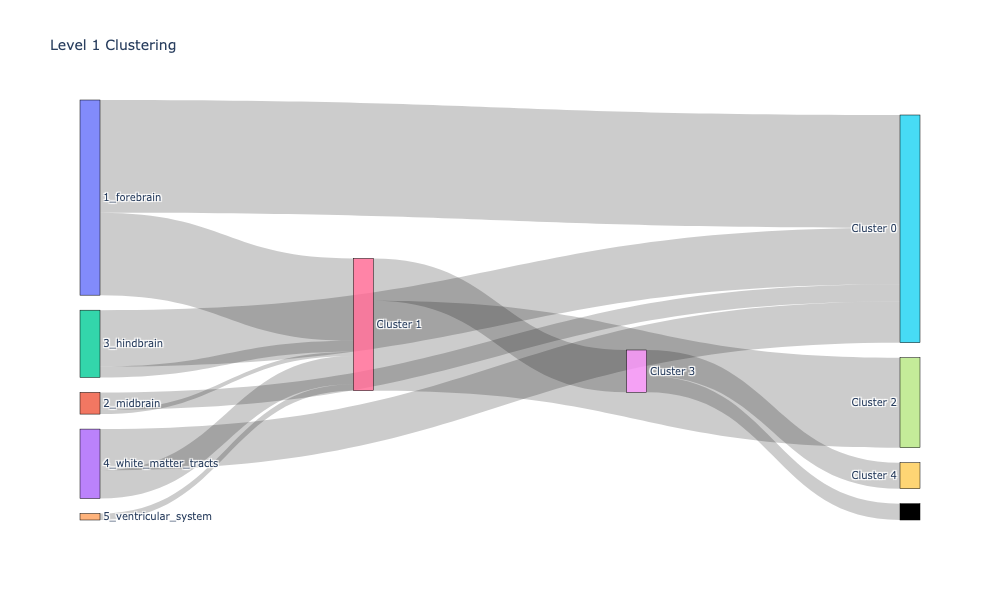

In [12]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = encoded_labels + [f"Cluster {i}" for i in range(np.max(level_1_clusters[0]))],
    ),
    link = dict(
      source = source,
      target = target,
      value = value
  ))])

fig.update_layout(title_text="Level 1 Clustering", font_size=10)
fig.show(dpi=300, width=1000, height=600)

In [13]:
pd.concat([node_labels, cluster_label_df], axis=1).to_csv("../outs/mase_clustering.csv", index=False)

## Visualizing different clustering levels using heatmaps

Heatmaps can qualitatively tell us if there are any underlying structures within the clusters.

In [14]:
cl = pd.DataFrame(cluster_labels, columns=[f"Cluster_{i}" for i in range(1, 4)])

meta = pd.concat([node_labels, cl], axis=1)

meta.head()

Structure Abbreviation Hemisphere      Level_1  \
0        Cingulate_Cortex_Area_24a         A24a       Left  1_forebrain   
1  Cingulate_Cortex_Area_24a_prime    A24aPrime       Left  1_forebrain   
2        Cingulate_Cortex_Area_24b         A24b       Left  1_forebrain   
3  Cingulate_Cortex_Area_24b_prime    A24bPrime       Left  1_forebrain   
4        Cingulate_Cortex_Area_29a         A29a       Left  1_forebrain   

                      Level_2      Level_3             Level_4 Subdivisions_7  \
0  1_secondary_prosencephalon  1_isocortex  2_cingulate_cortex    1_isocortex   
1  1_secondary_prosencephalon  1_isocortex  2_cingulate_cortex    1_isocortex   
2  1_secondary_prosencephalon  1_isocortex  2_cingulate_cortex    1_isocortex   
3  1_secondary_prosencephalon  1_isocortex  2_cingulate_cortex    1_isocortex   
4  1_secondary_prosencephalon  1_isocortex  2_cingulate_cortex    1_isocortex   

   index  index2  clusfound Subdivisions_7_nowm Hemisphere_abbrev  \
0      1     1.0          0         1_isocortex                 L   
1      2     2.0          0         1_isocortex                 L   
2      3     3.0          0         1_isocortex                 L   
3      4     4.0          0         1_isocortex                 L   
4      5     5.0          0         1_isocortex                 L   

  Level_1_abbrev  Cluster_1  Cluster_2  Cluster_3  
0              F          0          0          0  
1              F          1          2          2  
2              F          1          2          2  
3              F          1          3          5  
4              F          0          0          0

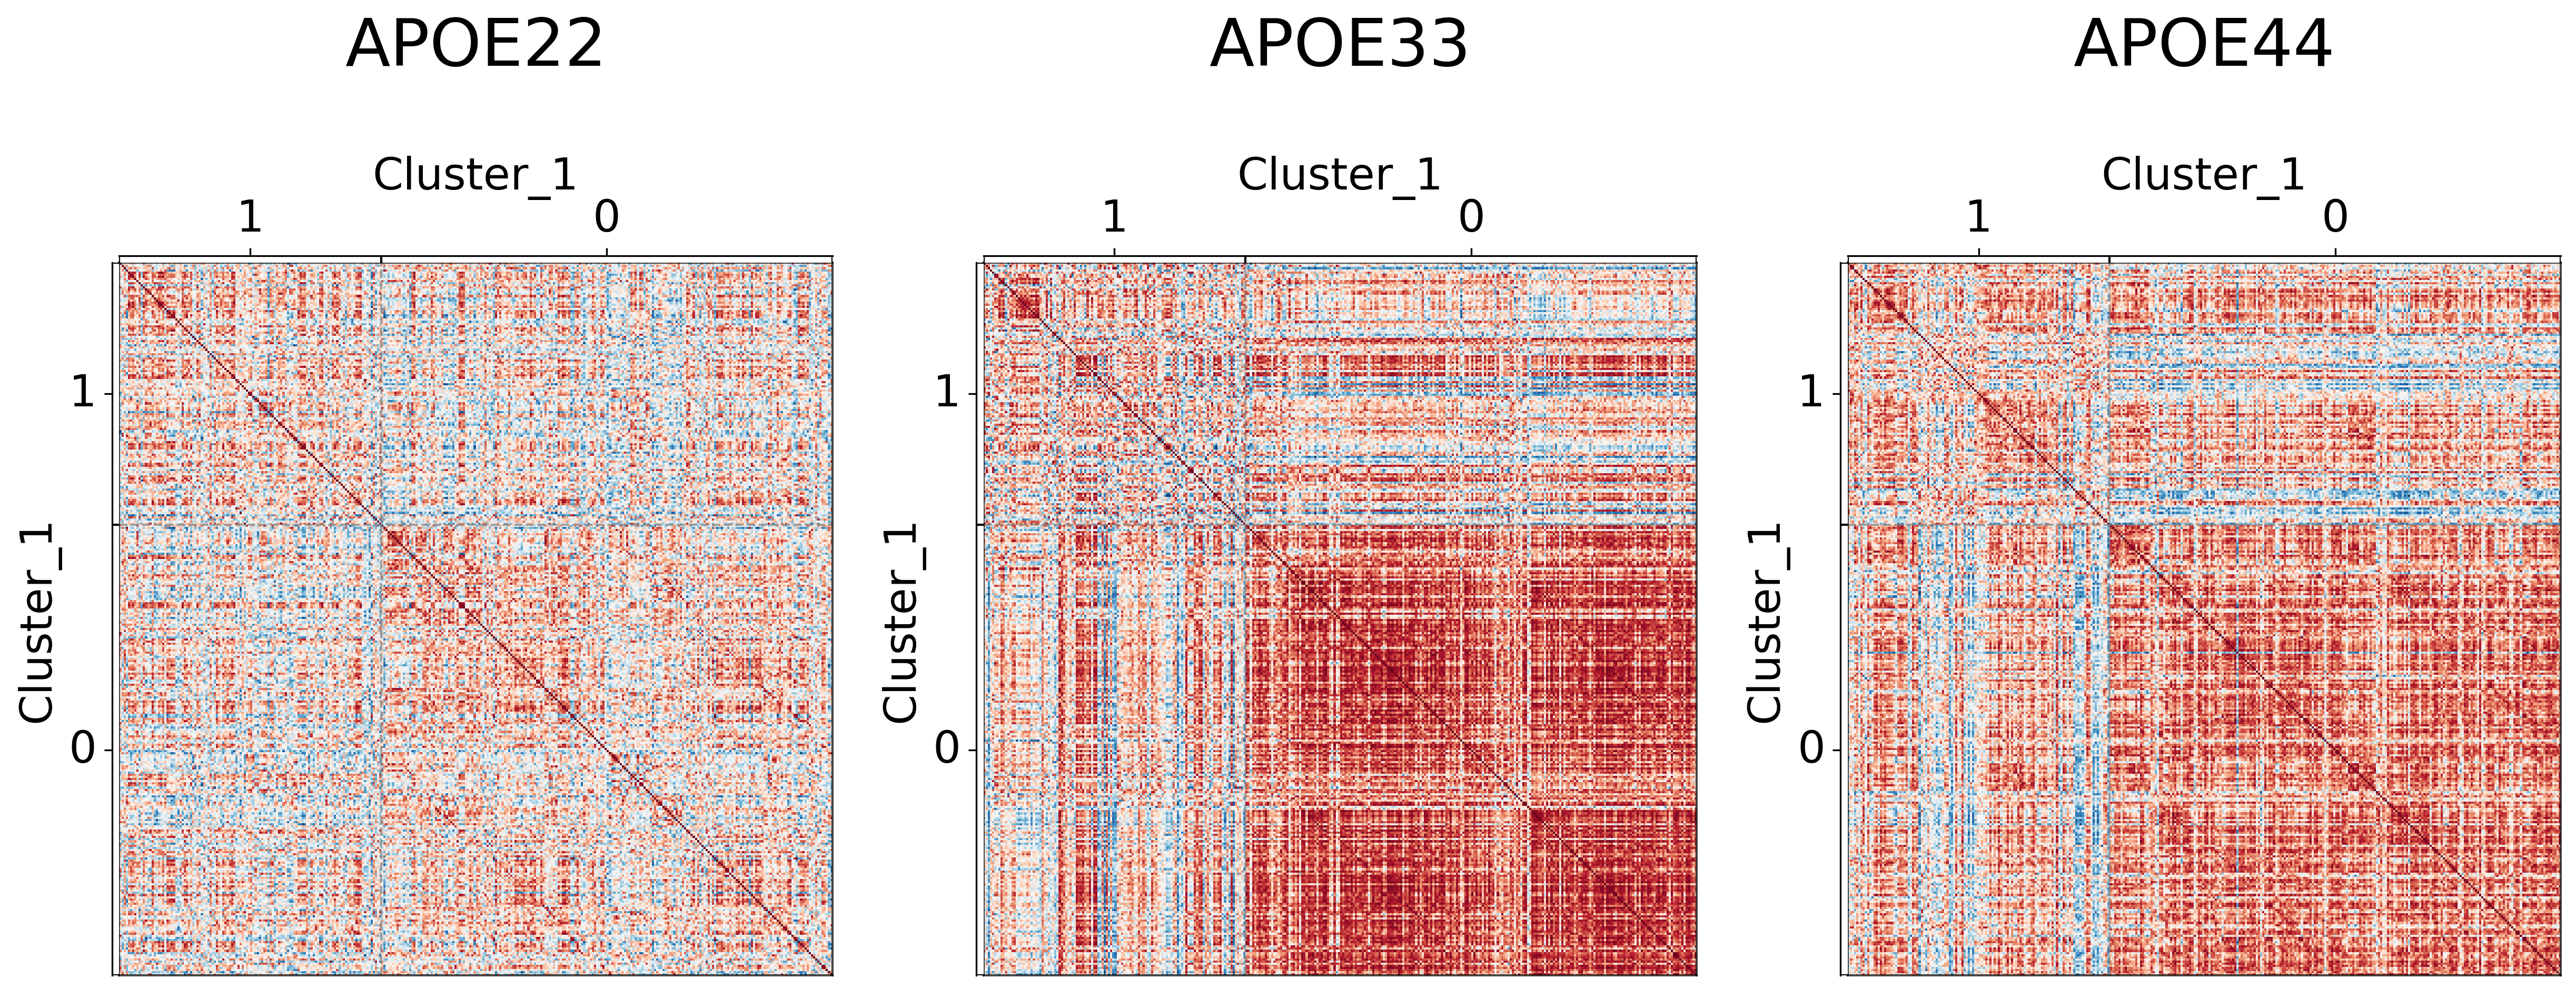

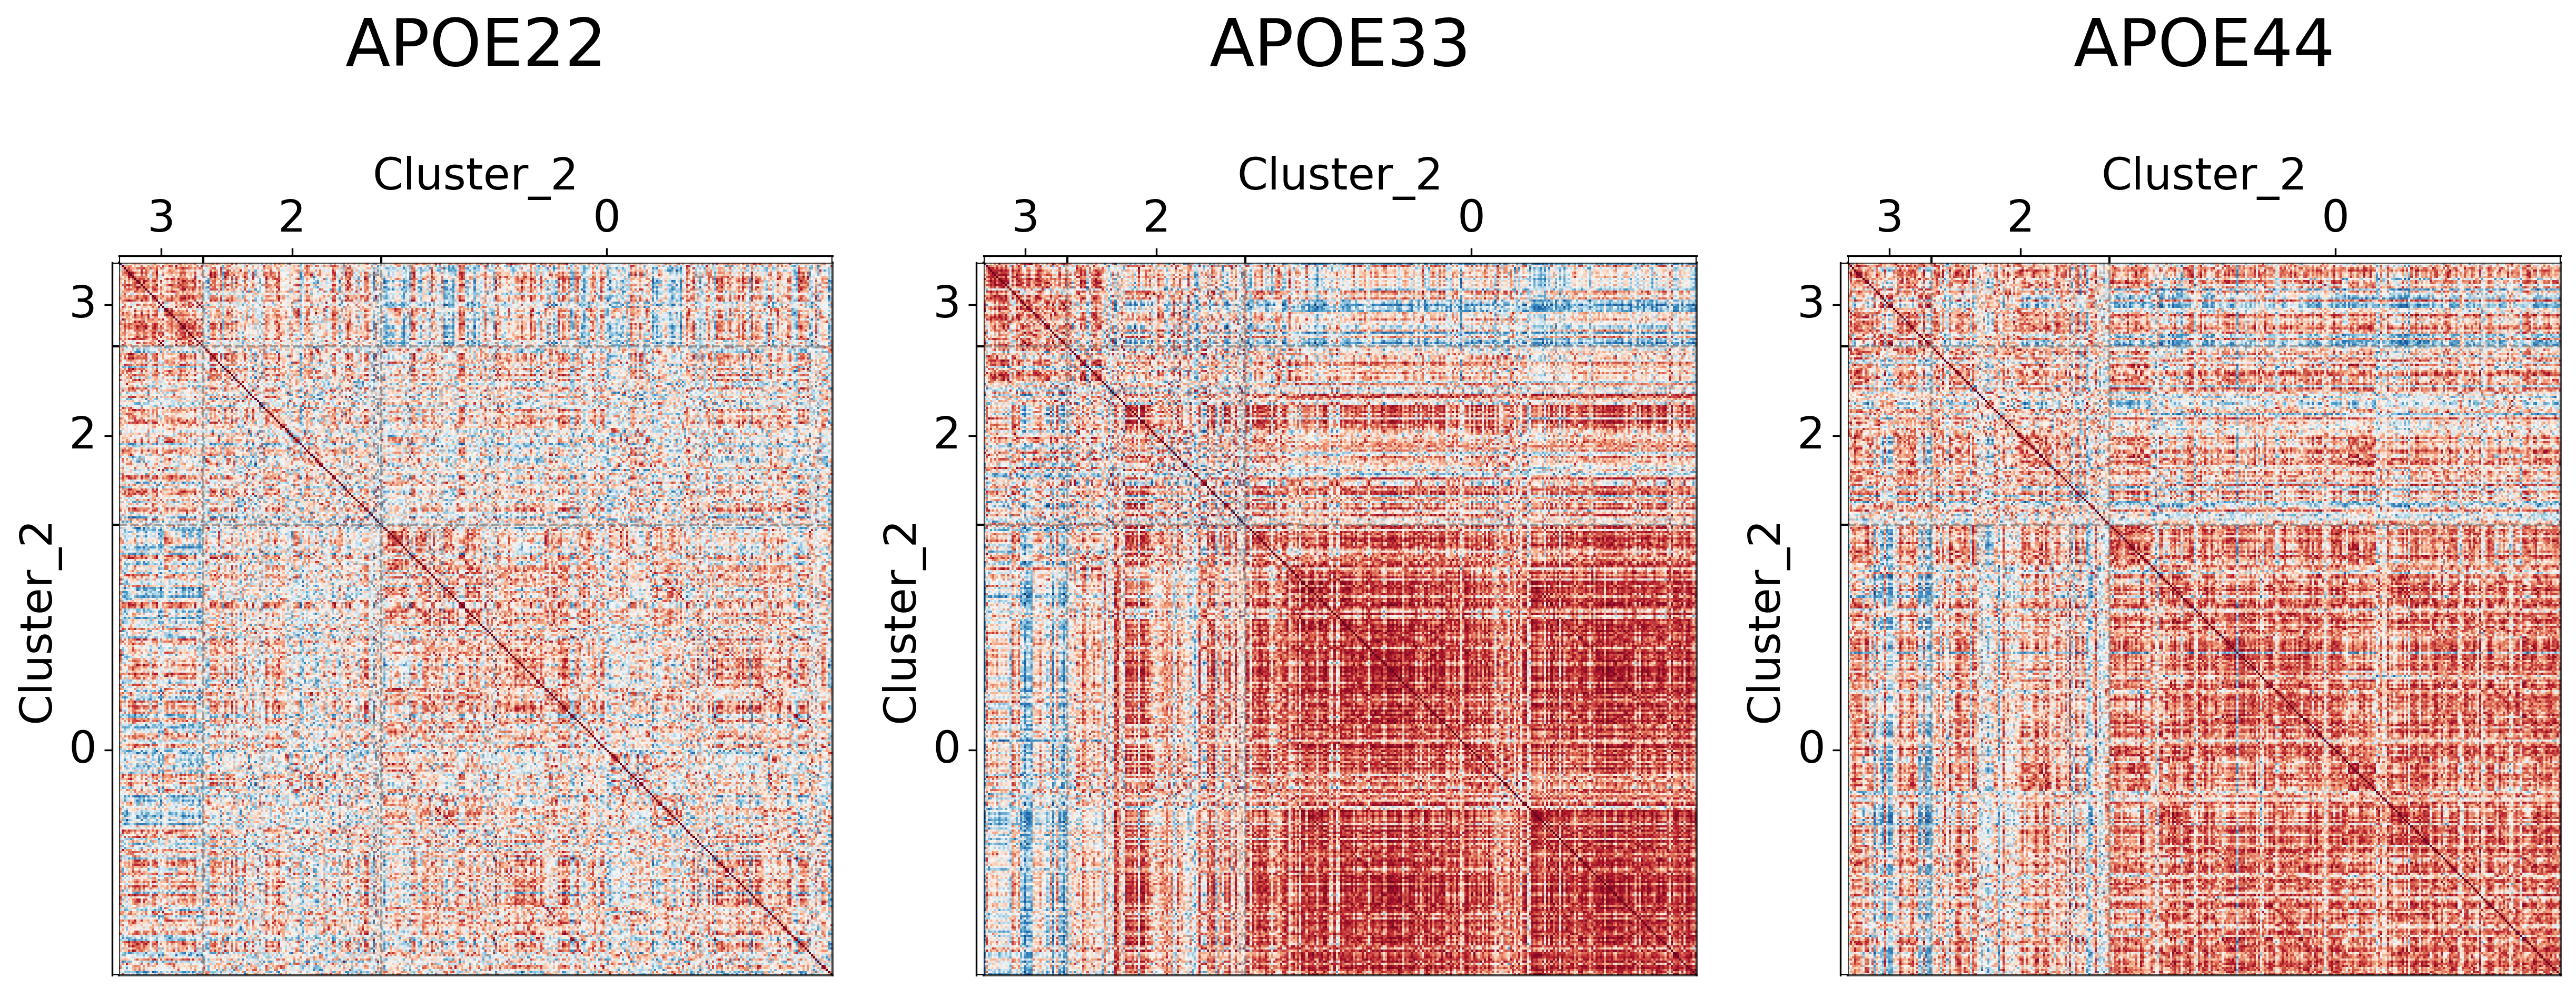

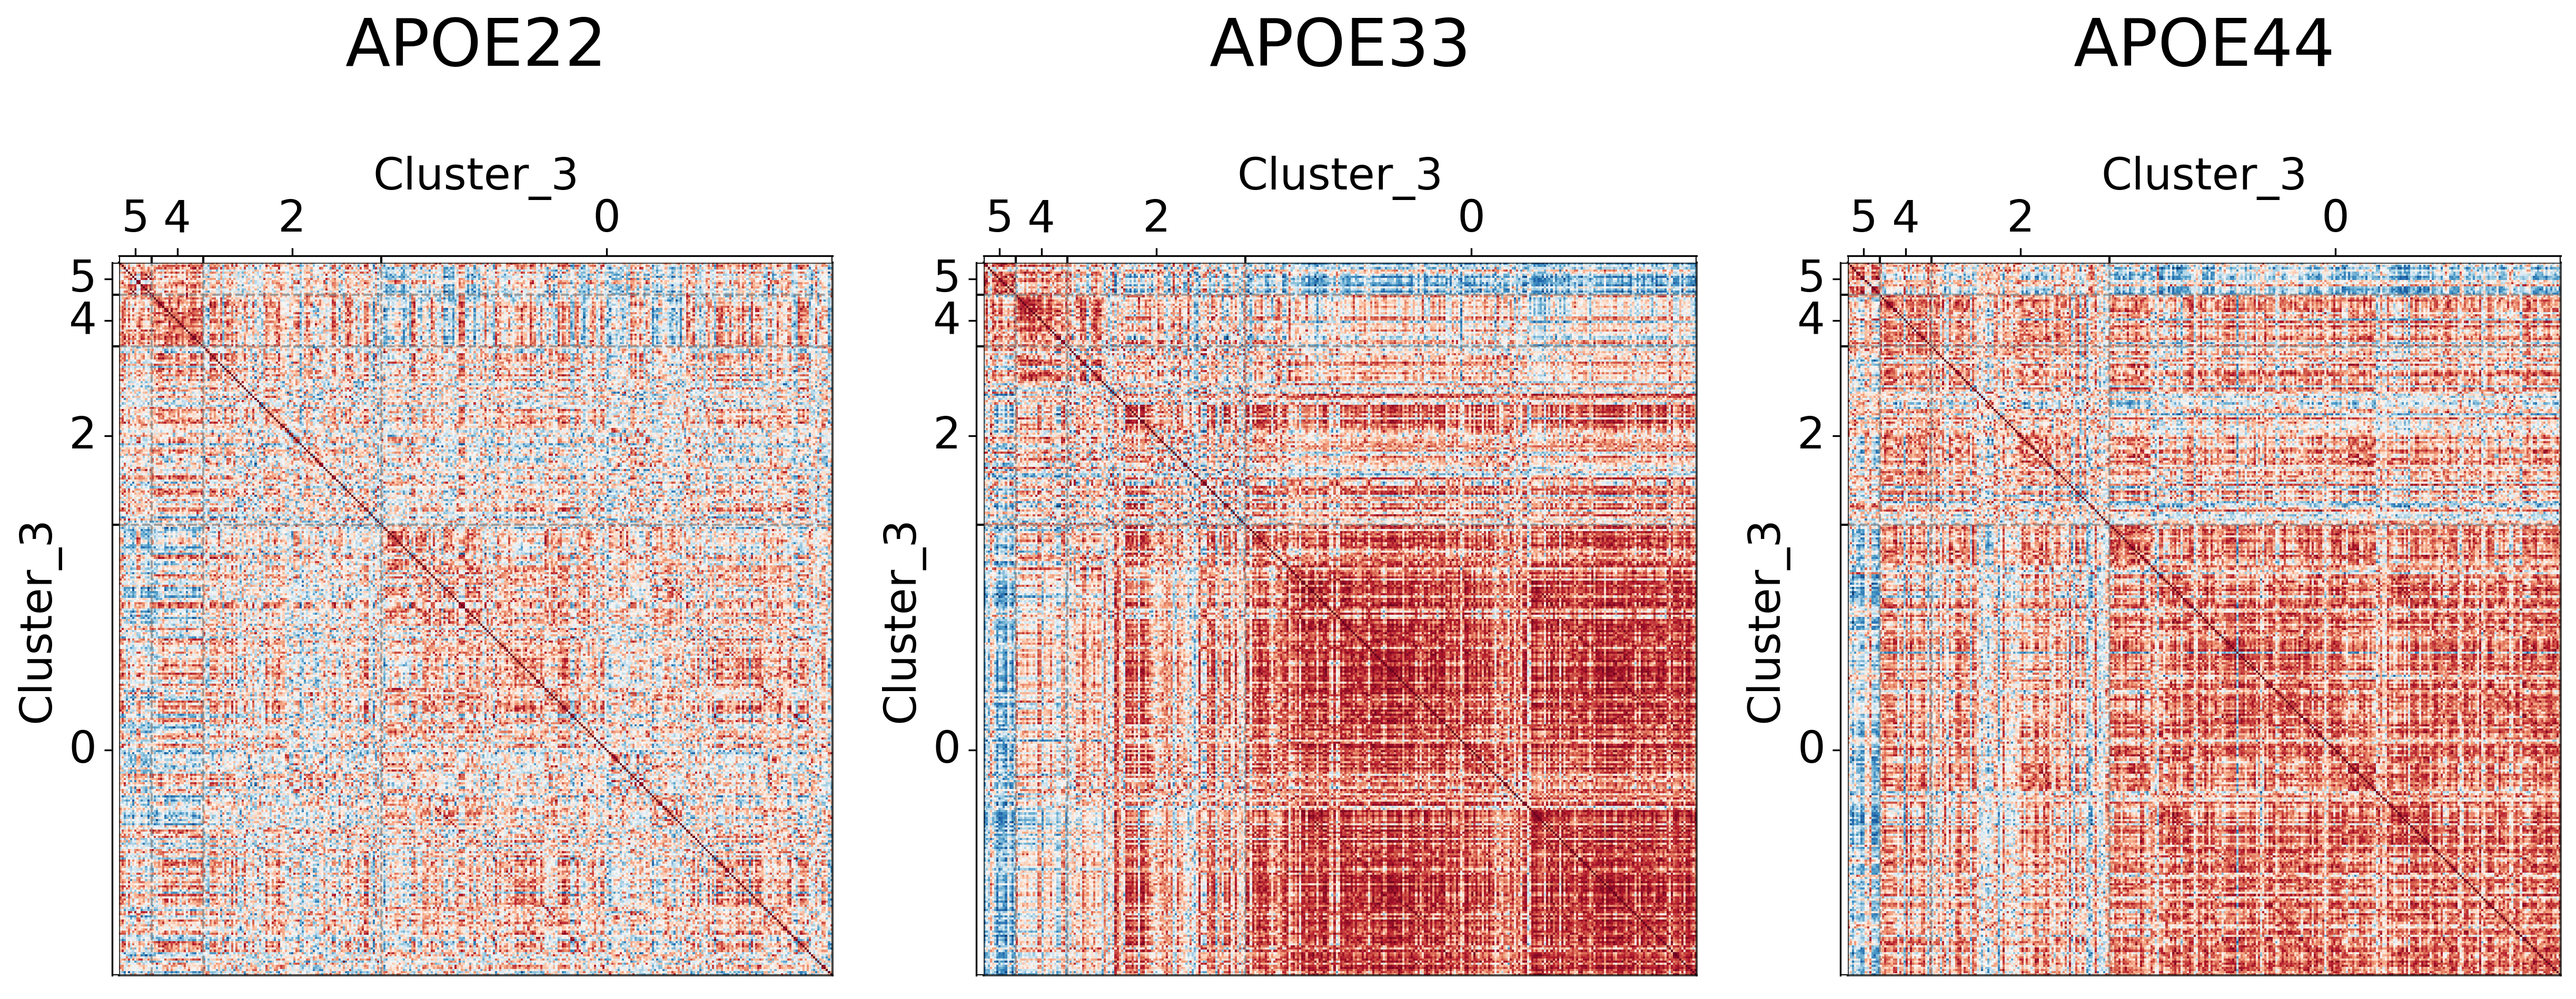

In [15]:
## Plot to make sure nothing is wrong
for l in range(3):
    fig, ax = plt.subplots(
        ncols=3, 
        figsize=(20, 10), 
        #constrained_layout=True, 
        dpi=300,
        gridspec_kw=dict(width_ratios=[1, 1, 1])
    )
    
    for (i, genotype) in enumerate(cor_dat.keys()):
        gp.plot.adjplot(
            cor_dat[genotype], 
            ax=ax[i],
            vmin=-1,
            vmax=1,
            meta=meta,
            group=[f'Cluster_{l+1}'],
        )
        ax[i].set_title(f"{genotype}", pad=90, size=30)
        
    #fig.savefig(f"./figures/2022-02-02-multigraph-clustering-level-{l + 1}.png", bbox_inches='tight')

It seems like cluster structures are predominantly driven by the large correlations in the APOE3 genotype

## Testing for significantly different clusters at various levels

Again, the clusters tell us which regions should be grouped together. Hence, each cluster forms our subgraph. For each subgraph, we test whether the distribution of the latent positions (aka the embeddings) are significantly different. Specifically we test 

\begin{align}
H_0:& \qquad F_{APOE2}=F_{APOE3}=F_{APOE4}\\
H_A:& \qquad \text{At least one pair of distributions is different}
\end{align}

using a 3-sample distance correlation. We correct for multiple hypothesis testing via Holm-Bonferroni correction.

In [16]:
def holm_bonferroni(pvals, alpha=0.05):
    sorted_pvals = np.sort(pvals)

    m = len(pvals)
    corrected_alpha = alpha / m
    
    for i in range(m):
        if sorted_pvals[i] < corrected_alpha:
            if (m + 1 - (i + 2)) == 0:
                return alpha / m
            corrected_alpha = alpha / (m + 1 - (i + 2))
        else:
            break
    
    return corrected_alpha

In [17]:
res = []

for level in range(cluster_labels.shape[1]):
    level_labels = cluster_labels[:, level]
    uniques = np.unique(level_labels)
    
    for cluster in uniques:
        idx = (level_labels == cluster)
        
        data = [Xhat[idx] for Xhat in Xhats]
        
        ksample = hyppo.ksample.KSample("dcorr")
        stat, pval = ksample.test(*data)
        
        res.append((level, cluster, pval))
        
ksample_df = pd.DataFrame(res, columns=["Cluster_level", "Cluster_id", "pval"])

corrected_alpha = holm_bonferroni(ksample_df.pval)

ksample_df["significant"] = ksample_df.pval < corrected_alpha

### Ksample testing results

We see that most clusters are significantly different.

In [18]:
ksample_df

Cluster_level  Cluster_id          pval  significant
0              0           0  1.774613e-51         True
1              0           1  1.149383e-12         True
2              1           0  1.774613e-51         True
3              1           2  2.072957e-07         True
4              1           3  1.937743e-12         True
5              2           0  1.774613e-51         True
6              2           2  2.072957e-07         True
7              2           4  1.825486e-12         True
8              2           5  5.191775e-07         True

### Testing for differences in pairwise subgraph covariances

The test above tells us whether a pair, or all, genotypes are different. For example, a significant result may mean that APOE2 and APOE3 are different. However, it is also possible that APOE2, APOE3, and APOE4 are all different. To figure out which pairs are different, we do a post-hoc pairwise test. That is, for each cluster (aka subgraph), we test whether each pair of genotypes are different. Specifically,

\begin{align}
H_0:& \qquad F_{i}=F_{j}\\
H_A:& \qquad F_i \neq F_j
\end{align}

where $i, j$ denotes a particular genotype. Again, we use distance correlation with Holm-Bonferroni correction.

In [19]:
genotypes = ['APOE22', 'APOE33', 'APOE44']

ksample = hyppo.ksample.KSample("dcorr")

res = []

cluster_df = ksample_df[ksample_df.significant == True]

for _, row in cluster_df.iterrows():
    cluster_id = row.Cluster_id
    idx = cluster_labels[:, row.Cluster_level] == cluster_id
    
    cluster_Xhat = [Xhat[idx] for Xhat in Xhats]

    for i, g in enumerate(genotypes):
        for j, h in enumerate(genotypes):
            if i < j:
                continue
            if g == h:
                #res.append([cluster_id, g, h, 1])
                continue
            else:
                ksample = hyppo.ksample.KSample("dcorr")

                _, pval = ksample.test(cluster_Xhat[i], cluster_Xhat[j])
                res.append([row.Cluster_level, cluster_id, g, h, pval])
                
res = pd.DataFrame(res, columns = ["cluster_level", "cluster_id", "Genotype_1", "Genotype_2", "pval"])
res["log(pval)"] = np.log(res.pval)

In [20]:
corrected_alpha = holm_bonferroni(res.pval)

res["significant"] = res.pval < corrected_alpha

In [21]:
from scipy.spatial.distance import squareform

In [22]:
dfs = [res[0:6], res[9:15], res[-6:]]

In [23]:
res = pd.concat(dfs, axis=0)

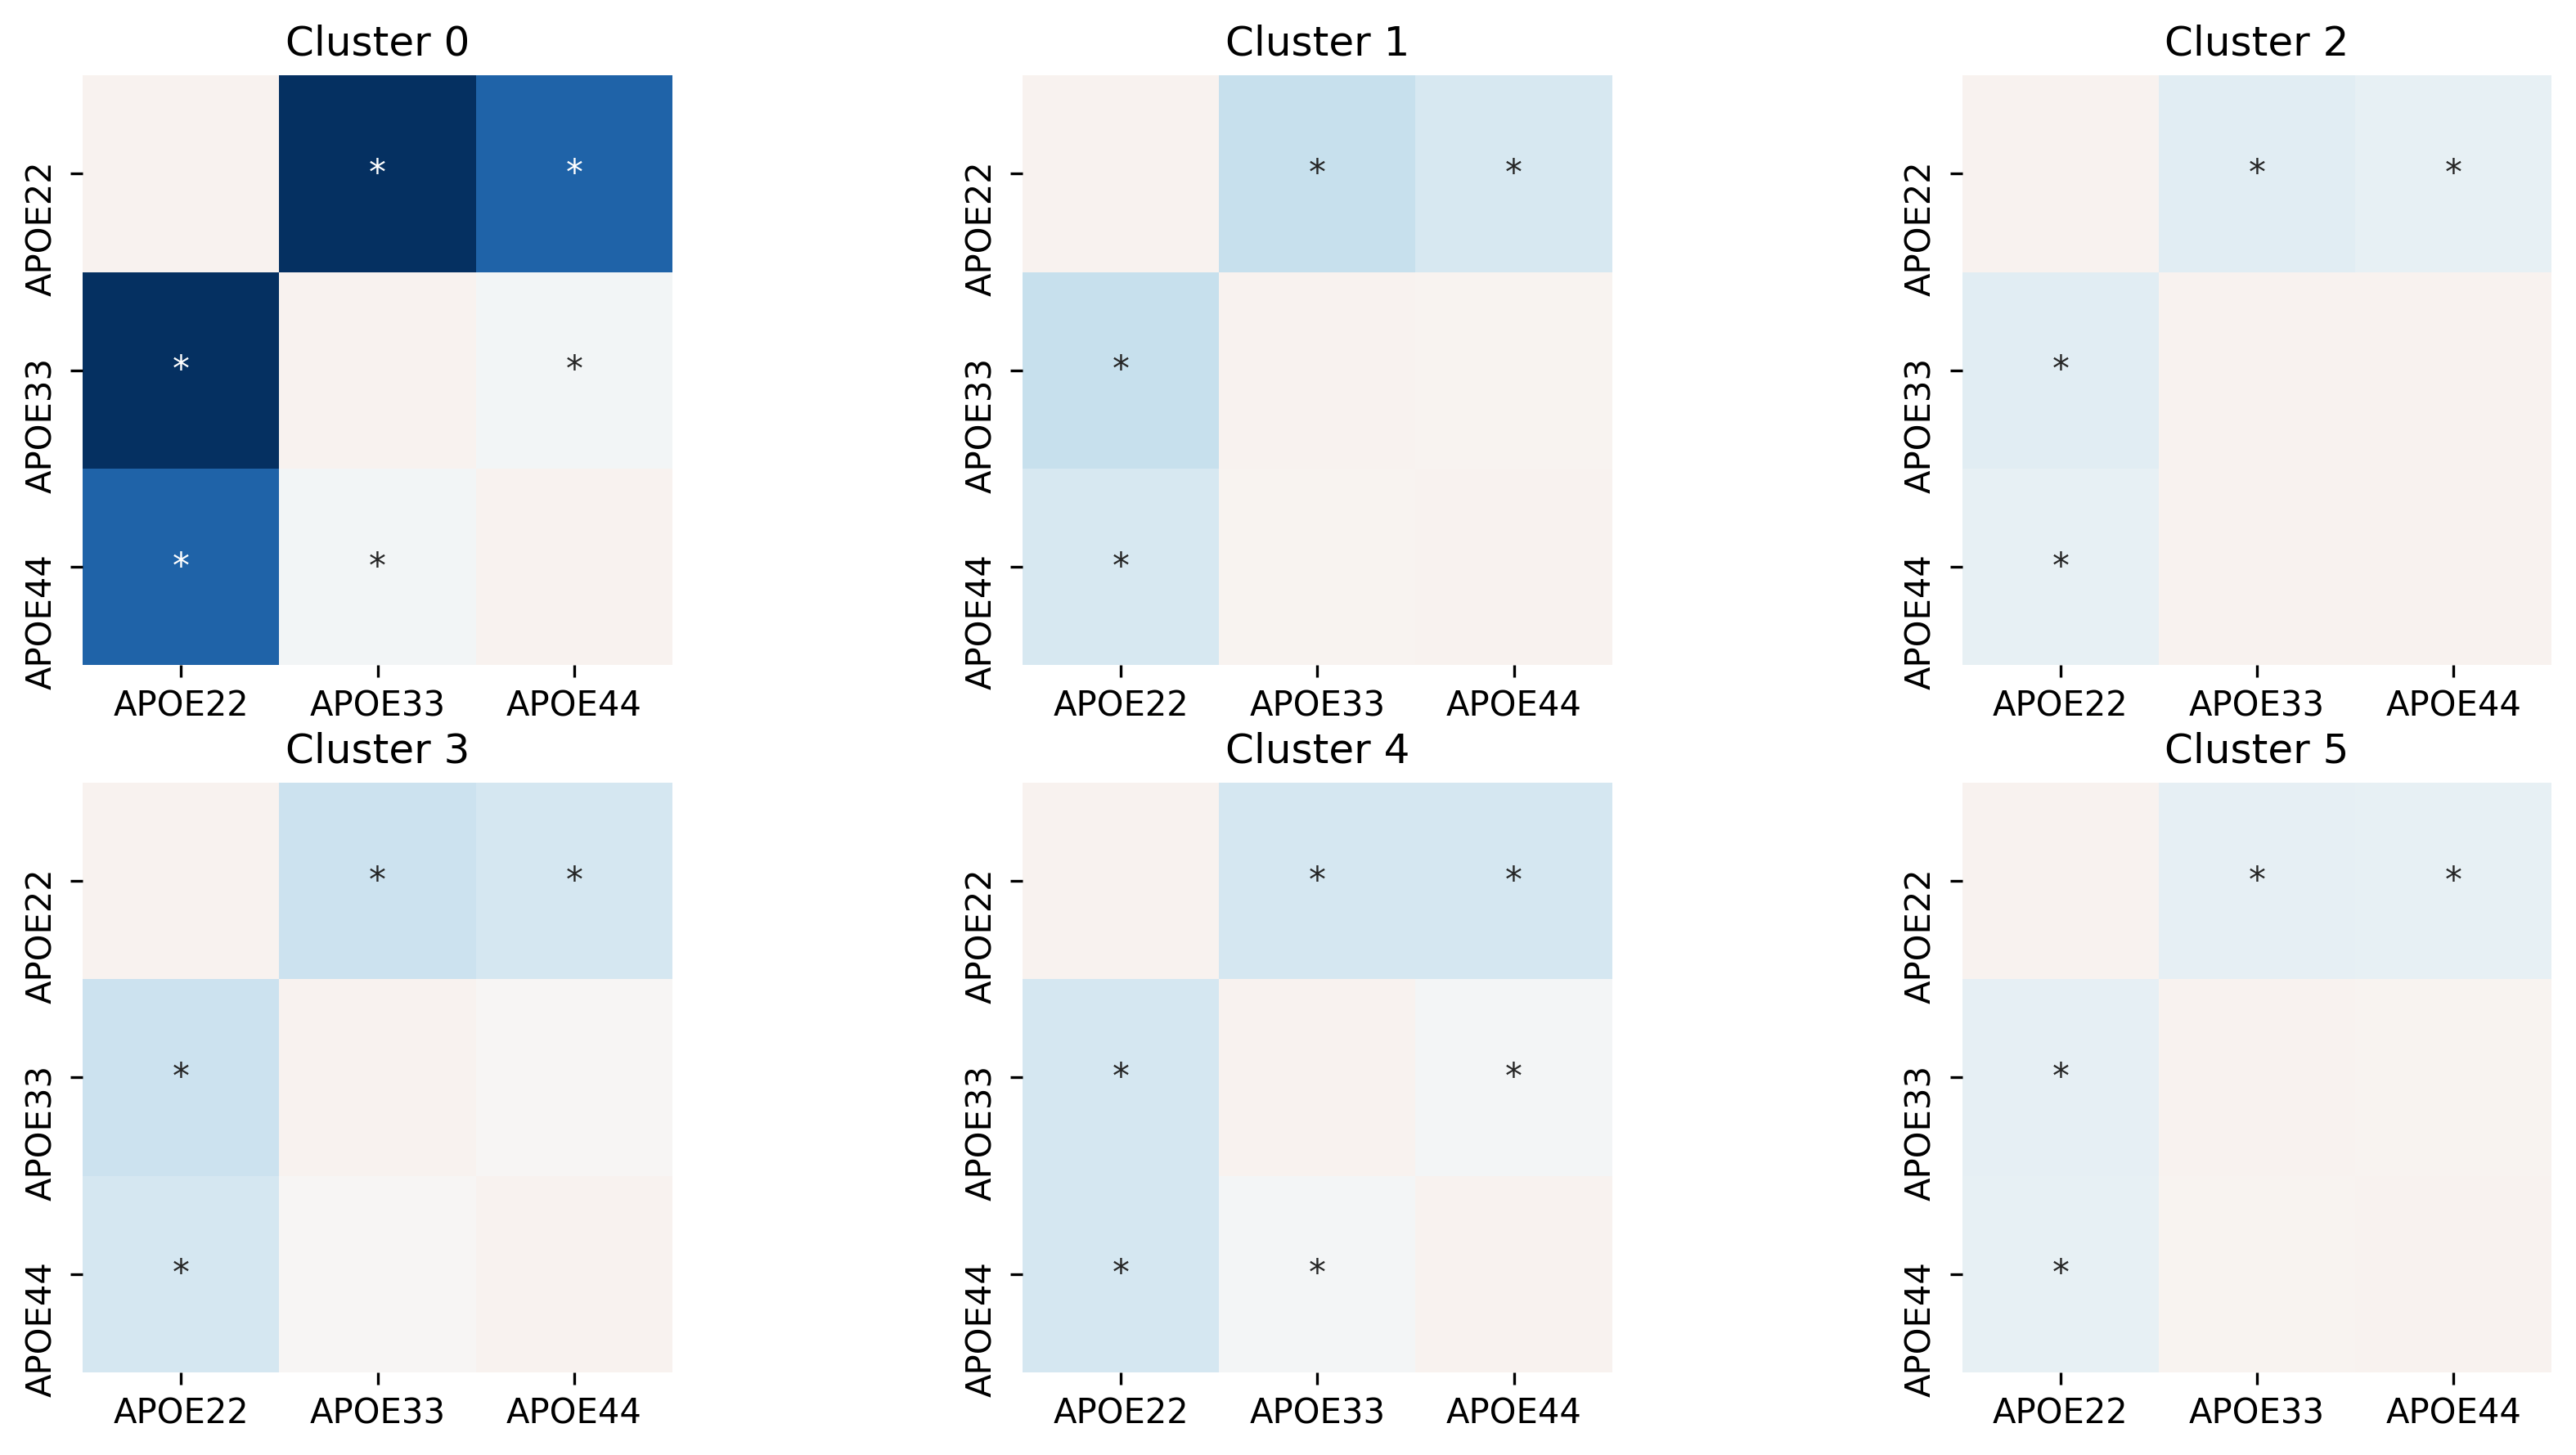

In [24]:
fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize=(14, 7), dpi=300)

ax = ax.ravel()

for i, cluster_id in enumerate(np.unique(res.cluster_id)):
    tmp = res[res.cluster_id == cluster_id]
    data = squareform(tmp["log(pval)"])
    sig_labels = squareform(["*" if sig is True else "" for sig in tmp.significant])
    sns.heatmap(
        data,
        annot=sig_labels,
        fmt = '',
        vmax=0, 
        vmin=np.min(res["log(pval)"]),
        xticklabels=genotypes,
        yticklabels=genotypes,
        center = np.log(corrected_alpha), 
        cmap="RdBu_r", square = True, ax = ax[i], cbar=False)
    ax[i].set_title(f"Cluster {cluster_id}")

In [25]:
#out = pd.concat([node_labels, cluster_label_df], axis=1)

#out.to_csv("./out.csv")

```{bibliography}
:filter: docname in docnames
```
